## Polaris Planck map

In [9]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


On a map ~4 times larger than the Herschel field.

INFO: Auto-setting vmin to -2.131e-06 [aplpy.core]
INFO: Auto-setting vmax to  4.970e-05 [aplpy.core]


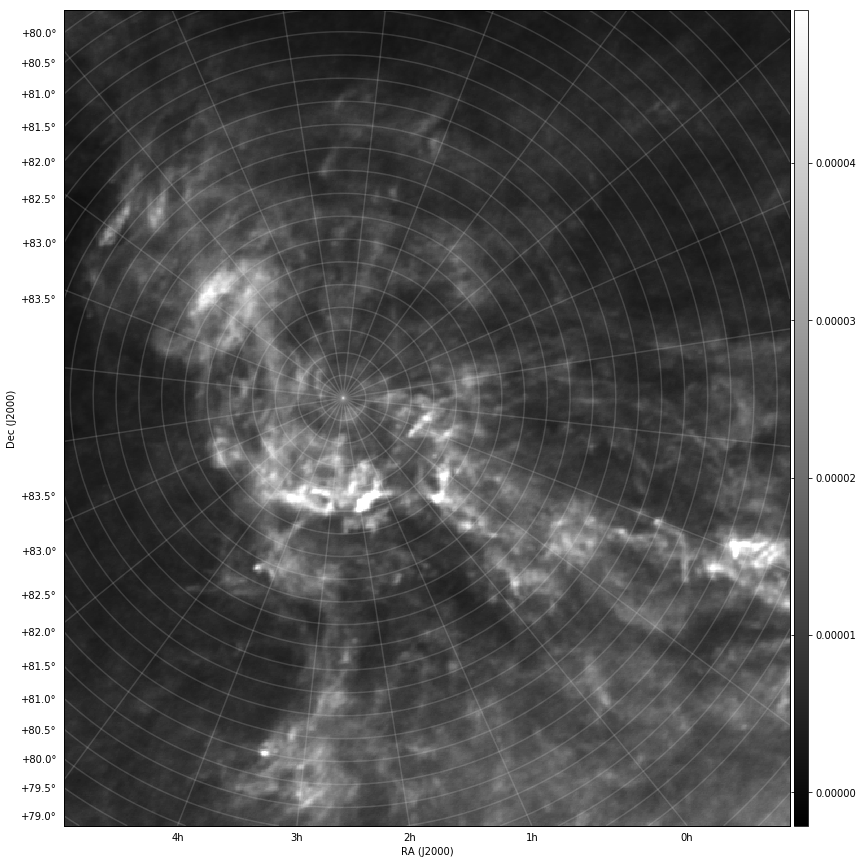

In [183]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Planck/HFI_tau353_polaris_6x_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [170]:
HDU = fits.open(figfile)
im = HDU[0].data / 1.2e-26
hdP = HDU[0].header
reso = hdP['CDELT2'] * 60.
im -= np.mean(im)

HDU2 = fits.open('/Users/robitaij/postdoc/Herschel/Gould Belt/HGBS_polaris_cdens_rot_cut.fits')
hdH = HDU2[0].header

Wavenumbers sampled with wavelets on the Herschel map.

In [171]:
wav_k = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wav_k_pola_hers.npy')
S1a = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/S1a_pola_hers.npy')
wt = np.load('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/wt_pola_hers.npy')

In [191]:
from powspec import powspec
from wavan import fan_trans, apodize, padding
from gauss_beam import gauss_beam
from astropy import wcs

800 800
[1.8999999999999995, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995, 1.7999999999999994, 1.8999999999999995, 1.8999999999999995, 1.8999999999999995]


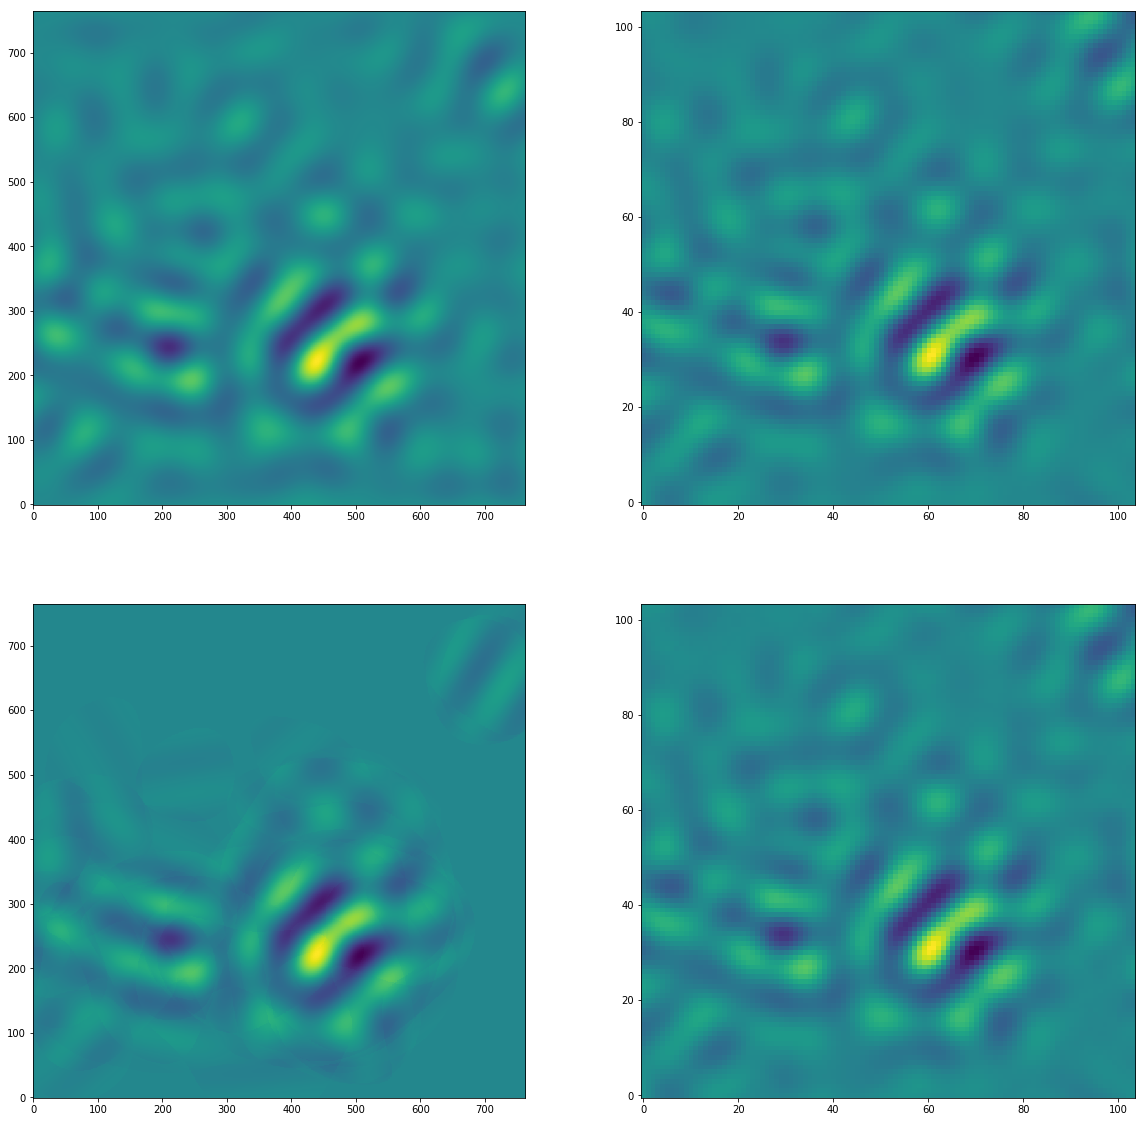

In [175]:
#q=[2.5]*9
#wtP, S11aP, wav_kP, S1aP, q = fan_trans(im, scales=wav_k[0:9], reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.98, arrdim = np.array([800,800]))

MP = wav_kP.size
M = wav_k.size

wP = wcs.WCS(hdP,HDU)
wH = wcs.WCS(hdH,HDU2)

wx0H, wy0H = wH.all_pix2world(0,0,0)
x0P, y0P = wP.all_world2pix(wx0H, wy0H,0)

wx1H, wy1H = wH.all_pix2world(HDU2[0].data.shape[1]-1,HDU2[0].data.shape[0]-1,0)
x1P, y1P = wP.all_world2pix(wx1H, wy1H,0)

scale = 8

figure(figsize=(20,20))
subplot(2,2,1)
imshow(wt[scale,:,:].real,origin='below')

subplot(2,2,2)
#imshow(wtP[2*M+scale,:,:].real,origin='below')
imshow(wtP[scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,origin='below')

subplot(2,2,3)
imshow(wt[M+scale,:,:].real,origin='below')

subplot(2,2,4)
#imshow(wtP[2*MP+scale,:,:].real,origin='below')
imshow(wtP[MP+scale,int(y0P):int(y1P),int(x0P):int(x1P)].real,origin='below')

print q

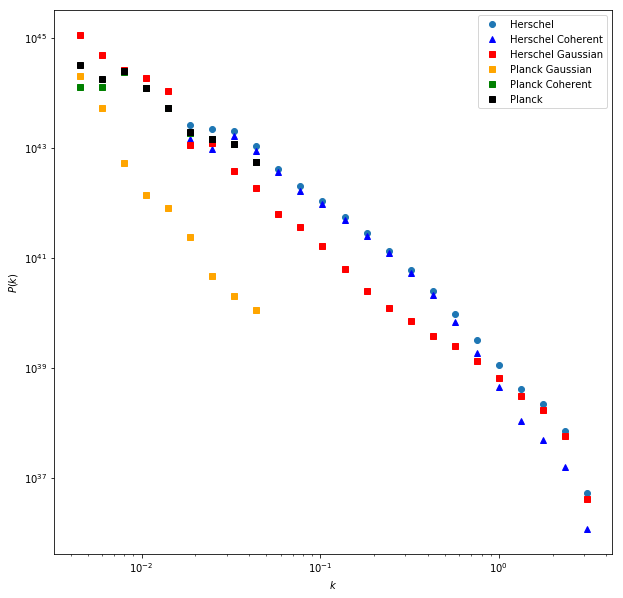

In [176]:
S1aPsub = np.mean(S11aP[0:MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))
S1aCPsub = np.mean(S11aP[MP:2*MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))
S1aGPsub = np.mean(S11aP[2*MP:3*MP,int(y0P):int(y1P),int(x0P):int(x1P)], axis=(1,2))

figure(figsize=(10,10))
plot(wav_k,S1a[0,:],'o',label='Herschel')
plot(wav_k,S1a[1,:],'^',color='blue',label='Herschel Coherent')
plot(wav_k,S1a[2,:],'s',color='red',label='Herschel Gaussian')
plot(wav_kP, S1aGPsub,'s',color='orange',label='Planck Gaussian')
plot(wav_kP, S1aCPsub,'s',color='green',label='Planck Coherent')
plot(wav_kP, S1aPsub,'s',color='black',label='Planck')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()

Planck field regular Power Spectrum

800 800
Power law Gaussian =  -3.6453260900273814 [0.11338743 0.50109296]
Power law coherent A =  -2.186633482266263 [0.17881167 0.78694496]
Gaussian noise =  1.0709616924430913e+40


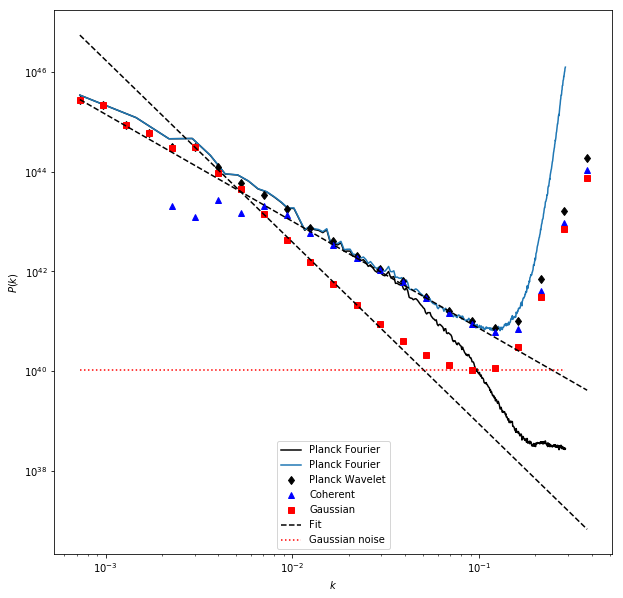

In [231]:
#Apodization

na = im.shape[1]
nb = im.shape[0]

tapper = apodize(nb,na,0.98)
imt = im *tapper
imr = padding(imt,800,800)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
#FWHM = 4.86 / (reso)  #Beam size at 353 GHz (Planck)
FWHM = 5.5 / (reso)  #Beam size at 353 GHz (Planck)
beam = gauss_beam(FWHM,800,800,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
#BS1an = BS1a / BS1a[4]

#Wavelet power spectrum
q = [1.9]*24

wtPo, S11aPo, wav_kPo, S1aPo, qo = fan_trans(im, reso=reso, q=q, qdyn=False, skewl=0.4, apodize= 0.98, arrdim = np.array([800,800]))

MPo = wav_kPo.size
S1aPon = np.copy(S1aPo)

S1aPon[0,3:] = S1aPo[0,3:]/BS1an[3:]
S1aPon[1,3:] = S1aPo[1,3:]/BS1an[3:]
S1aPon[2,3:] = S1aPo[2,3:]/BS1an[3:]

figure(figsize=(10,10))
plot(tab_k, spec_k,color='black',label='Planck Fourier')
plot(tab_k, spec_k/spec_beamn,label='Planck Fourier')
plot(wav_kPo, S1aPon[0,:],'d',color='black',label='Planck Wavelet')
plot(wav_kPo, S1aPon[1,:],'^',color='blue',label='Coherent')
plot(wav_kPo, S1aPon[2,:],'s',color='red',label='Gaussian')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')

#Power law fit
coef,cov = np.polyfit(np.log(wav_kPo[7:14]),np.log(S1aPon[2,7:14]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_kPo**coef[0]

coef2,cov2 = np.polyfit(np.log(wav_kPo[10:18]),np.log(S1aPon[1,10:18]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*wav_kPo**coef2[0]

#coef3,cov3 = np.polyfit(np.log(wav_kPo[8:13]),np.log(S1aPon[1,8:13]),deg=1,cov=True)
#yfit3 = np.exp(coef3[1])*wav_kPo**coef3[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))
print "Power law coherent A = ", coef3[0], np.sqrt(np.diag(cov3))
#print "Power law coherent B = ", coef2[0], np.sqrt(np.diag(cov2))

plot(wav_kPo, yfit, '--', color='black', label='Fit')
plot(wav_kPo, yfit2, '--', color='black')
#plot(wav_kPo, yfit3, '--', color='black')

#Gaussian noise
plot([np.min(tab_k),np.max(tab_k)], [S1aPon[2,17],S1aPon[2,17]], ':', color='red',label="Gaussian noise")

print "Gaussian noise = ", S1aPon[2,17]

plt.legend()

[2.1, 2.1, 2.1, 2.1, 1.1999999999999993, 2.0, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.9, 1.7999999999999998, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 2.1]
wav_kPo.shape[0]= 23


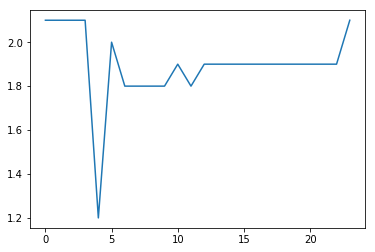

In [227]:
print q
print 'wav_kPo.shape[0]=',wav_kPo.shape[0]

x = range(24)
plot(x,np.array(q).reshape(24))

INFO: Auto-setting vmin to -1.232e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.803e+21 [aplpy.core]
INFO: Auto-setting vmin to -1.394e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.364e+21 [aplpy.core]


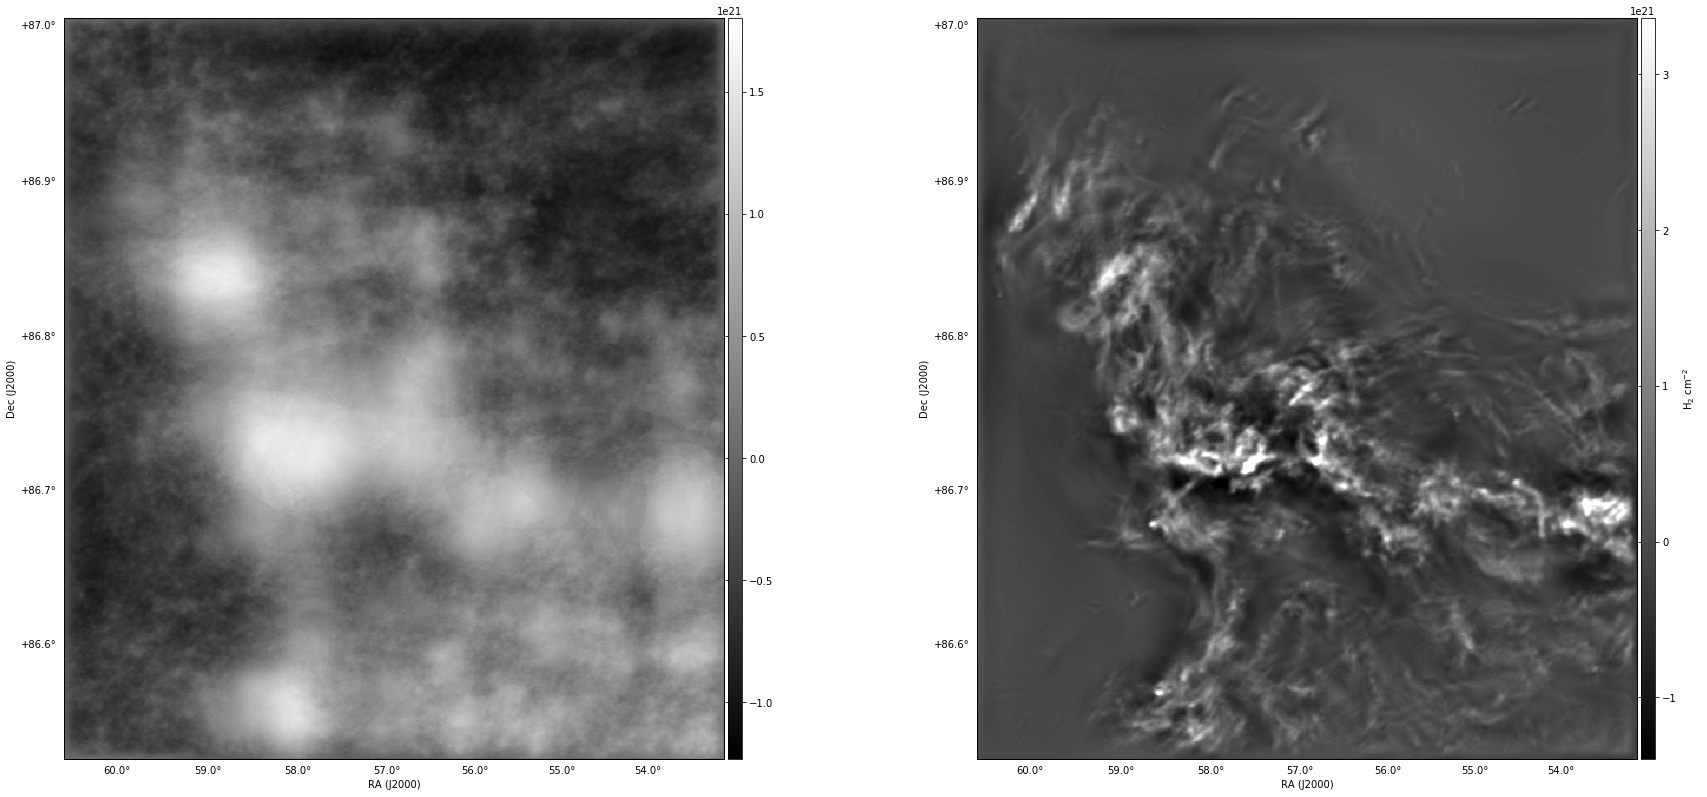

In [228]:
coherent = np.sum(wtPo[MPo:2*MPo,:,:],axis=0)
Gaussian = np.sum(wtPo[2*MPo:3*MPo,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Planck/analysis/HFI_tau353_polaris_cohe.fits',\
            coherent.real,HDU2[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Planck/analysis/HFI_tau353_polaris_gaussian.fits',\
            Gaussian.real,HDU2[0].header,overwrite=True)

fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Planck/analysis/HFI_tau353_polaris_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Planck/analysis/HFI_tau353_polaris_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

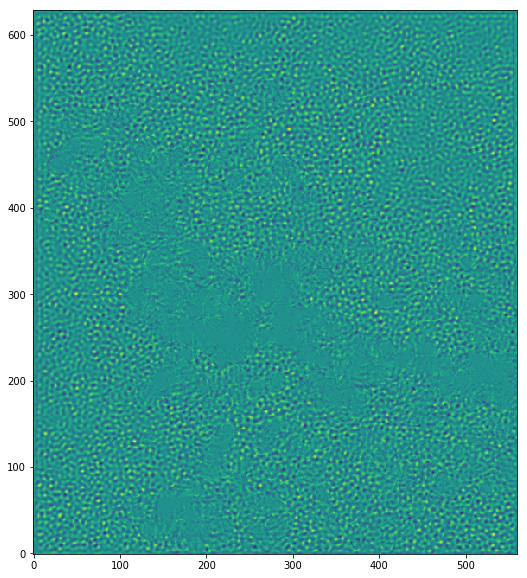

In [229]:
#Gaussian noise
figure(figsize=(10,10))
imshow(np.sum(wtPo[2*MPo+17:2*MPo+18,:,:],axis=0).real,origin='below')

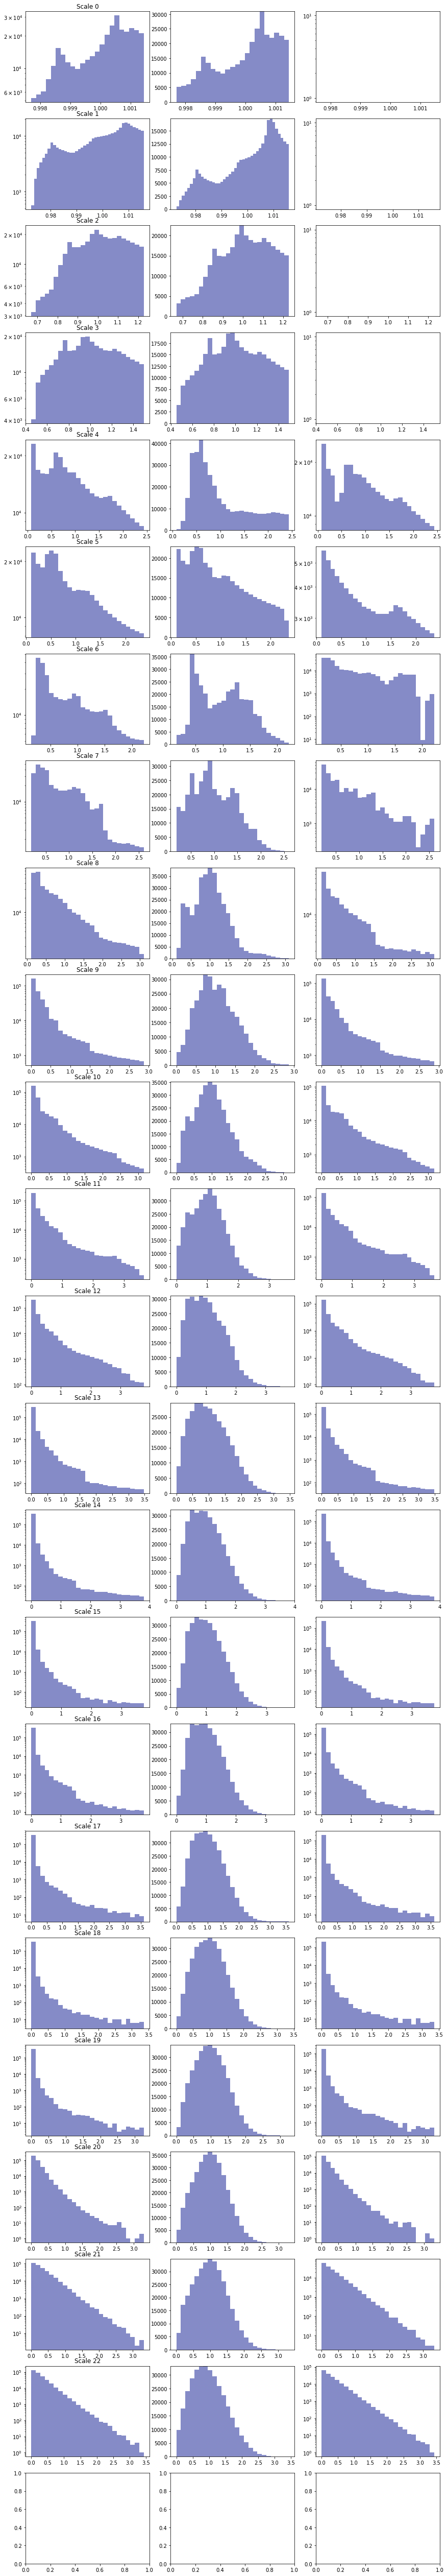

In [230]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(MPo):
    
    if np.mean(S11aPo[MPo+i,:,:]) !=0:
        wc = (S11aPo[MPo+i,:,:])/np.mean(S11aPo[MPo+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11aPo[i,:,:])/np.mean(S11aPo[i,:,:])
    wg = (S11aPo[2*MPo+i,:,:])/np.mean(S11aPo[2*MPo+i,:,:])
    
    #Number of independent points
    npix = np.int((im.shape[0] * wav_k[i]*reso)**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=25
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3].set_title('Scale '+np.str(i))
    axs[i*3].set_yscale('log')
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+1].set_ylim((0,np.max(histo_g)))
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+2].set_yscale('log')